In [7]:
import jax
from jax.numpy.fft import fft, ifft
import jax.numpy as jnp
import matplotlib.pyplot as plt  
from jax import grad, vmap


import sys
root = '/home/emastr/github/phd/projects/vahid_project/'
sys.path.append('..')
sys.path.append(f'{root}src/')
sys.path.append(f'{root}util/')
sys.path.append(f'{root}data/')
from multiprocessing import Pool
from matplotlib.colors import LogNorm
from alignment_vmap import *
from alignment_vmap import em_method, fix_point_iter, align_average, autocorr_fft, hessian_declarative, hessian_declarative_real
from alignment_vmap import align_average_and_project, align, invariants_from_data, bispectrum_inversion

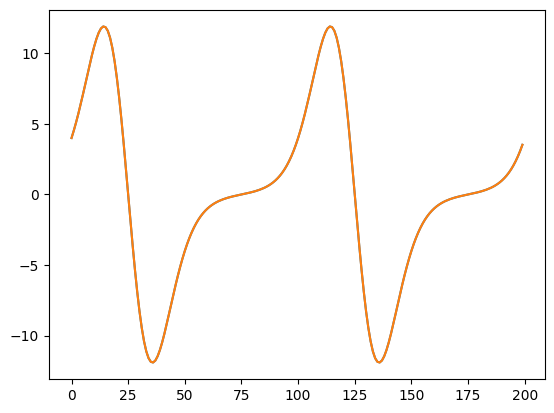

In [8]:
def get_signal(L):
    t = jnp.linspace(0, 2*np.pi, L+1)[:-1]
    x = (t < np.pi).astype(float)
    return t, x

def get_samples(key, x, noise_std, N):
    L = len(x)
    shiftkey, noisekey = jax.random.split(key, 2)
    shift = jax.random.randint(shiftkey, (N,), 0, L)
    noise = jax.random.normal(noisekey, (N, L)) * noise_std
    y = vmap(lambda s, z: jnp.roll(x + z, s), in_axes=(0, 0))(shift, noise)
    return y, noise, shift



t = jnp.linspace(0, 2*jnp.pi, 201)[:-1]
f = lambda t: jnp.exp(2*jnp.sin(2*t))
x = f(t)
dx = vmap(grad(f))(t)

ks = jnp.fft.fftfreq(len(t), 2*jnp.pi/len(t))


xfft = fft(x)
dxfft = 1j * ks * xfft * 2*jnp.pi

#plt.plot(ifft(xfft).real)
plt.plot(dx)
plt.plot(ifft(dxfft).real)
#plt.plot(x)


In [9]:
t = jnp.linspace(0, 2*jnp.pi, 103)[:-1]
f = lambda t: 1/(1 + jnp.exp(-jnp.sin(t)/0.15)) #jnp.exp(2*jnp.sin(2*t))
#f = lambda t: jnp.exp(2*jnp.sin(2*t))
stdev = 0.2
N = 100
x = f(t)
y, noise, shift = get_samples(random.PRNGKey(4), x, stdev, N)
xfft = fft(x)
yfft = fft(y, axis=1)


def hes_fourier(xfft, yfft):
    
ks = jnp.fft.fftfreq(len(t), 2*jnp.pi/len(t)) * 1j * 2 * jnp.pi

# truncate by setting ks to zero for large frequencies
ks = ks * (jnp.abs(ks) < 100)

dyfft = ks * yfft
dxfft = ks * xfft

diff = lambda x: (x - jnp.roll(x, len(x)//10))/float(len(x)//10)*float(len(x))

dx = vmap(grad(f))(t) #diff(x)
dy = vmap(lambda s: jnp.roll(dx, s))(shift) #diff(y) # True dy


outer = lambda x, y: jnp.einsum('i,j->ij', x.conj(), y)
inner = lambda x, y: jnp.einsum('i,i->', x.conj(), y)
#plt.plot(y)
#plt.plot(x)
print(inner(dyfft, dxfft), inner(dy, dx))
I = jnp.eye(len(x))
Afft = I  - outer(dyfft, dyfft)/inner(dyfft, dxfft)
A = I - outer(dy, dy)/inner(dy, dx)# * len(x)

ifftAfft = ifft(ifft(Afft.conj(), axis=0).conj(), axis=1) * len(x)#* 0.0047545317

print(1/(jnp.linalg.norm(ifftAfft) / jnp.linalg.norm(A)))

plt.subplot(221)
plt.title("Hessian Autograd")
plt.imshow(A)
plt.colorbar()

plt.subplot(222)
plt.title("Hessian FFT")
plt.imshow(ifftAfft.real)
plt.colorbar()

plt.subplot(223)
plt.title("Hessian FFT")
plt.imshow(ifftAfft.real)
plt.colorbar()

plt.subplot(224)
plt.title("Hessian FFT")
plt.imshow(ifftAfft.real)
plt.colorbar()

plt.tight_layout()
#plt.colorbar()
plt.figure()
plt.plot(x)

NameError: name 'roll' is not defined

In [ ]:
x = jnp.sin(t)
y = jnp.roll(x, 10)

print(jnp.sum(x * y))
print(jnp.sum(fft(x).conj() * fft(y)) / len(x))


41.626038
(41.626045+0j)
